# 3D House project

This project consists of plotting an interactive 3D Surface Graph of a house, based on the address provided. The region covered is the region of Flanders (Belgium).

The data are *Lidar* data. The region is divided into 43 rasters. Each raster is in the format **.tif** . This program will select the correct raster after getting from an API the geospatial coordinates corresponding to the address of the house.

## 1. Libraries

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon

import rasterio # Tif files
import os
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
from plotly.graph_objs import *
from rasterio.plot import show
from rasterio.mask import mask

import requests
import json

## 2. Address and coordinates

In [3]:
street_name = input("Street name: ")

Street name:  Sint-Pietersvliet


In [4]:
house_number = int(input("House number: "))

House number:  7


In [5]:
post_code = int(input("Post code: "))

Post code:  2000


In [6]:
house_address = f'{street_name} {house_number} {post_code}' # Will be use for the title of the 3D plot later on

In [7]:
# Address request to the basisregisters Vlaanderen API

# HTTP request to the API
address = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch",
                      params={'postcode': post_code, 'straatnaam': street_name, 'huisnummer':house_number})

address = address.json() # Convert http request's response into json format

In [8]:
def get_coordinates(address):
    """
    Function that get the geospatial coordinates and separate the latitude and longitude
    in two different lists (lat, lon).
    """

    address = address['adresMatches'][0]
    
    norm = pd.json_normalize(address)
    norm = norm.loc[0,'adresseerbareObjecten']
    block_url = norm[0].get('detail')
    block_url
    
    # Second request
    address = requests.get(block_url)
    block_details = address.json()
    block_details
    
    building = block_details.get('gebouw')
    url_house = building.get('detail')
    
    # Third request
    house = requests.get(url_house)
    house_details = house.json()


    df = pd.json_normalize(house_details) # Convert the json format into a Pandas DataFrame
    
    house_coordinates = df.loc[0,'geometriePolygoon.polygon.coordinates']
    lat_lon = []

    # Write geometry coordinates to a list
    for list in house_coordinates:
        for sublist in list:
            for coordinates in sublist:
                print(coordinates, end='\n')
                lat_lon.append(coordinates)

    lat = []
    lon = []

    for i, coords in enumerate(lat_lon):
        if i % 2 == 0:
            lat.append(coords)
        else:
            lon.append(coords)

    return lat, lon

In [9]:
lat, lon = get_coordinates(address)

152234.7539967969
212884.87605375424
152234.82894080132
212884.9189977534
152234.7067647949
212885.13282175362
152234.54202879965
212885.42107775435
152221.9368447885
212878.215253748
152216.66906878352
212875.20392574742
152215.47796478122
212874.52302974463
152215.7520127818
212874.04302974418
152215.85204478353
212874.10197374597
152216.04097278416
212873.7709657438
152225.4219647944
212857.33397373557
152225.34394878894
212857.28994173557
152231.24206079543
212846.96808572486
152231.36404479295
212847.0380377248
152246.52404480428
212820.42696570978
152246.43796480447
212820.37493370846
152246.70881280303
212819.90990970656
152246.73498880863
212819.8649817072
152246.9969408065
212820.01717370749
152247.5319168046
212820.3279577084
152249.9582208097
212816.06210170686
152251.11796481162
212814.0229977034
152251.02298881114
212814.00994170457
152251.31399680674
212813.5079897046
152268.9353088215
212823.58363771066
152268.96398082376
212823.60002170876
152268.93748482317
212823.6489

## 3. Creation of the polygon

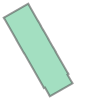

In [10]:
polygon_geometry = Polygon(zip(lat, lon)) # Geometry
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:31370', geometry=[polygon_geometry])

polygon_geometry

## 4. Selection of the raster

All the rasters are located in the local drive and separated in two distincts folders (/DSM and /DTM)

In [11]:
def select_raster(coordinates):
    """
    Function that select the correct raster based on the coordinates of the address.
    """
    
    df = pd.read_csv('Utils/rasters_lambert_coordinates.csv') # Load the csv file
    

    # Search for the correct raster
    raster = df[(df['Left'] < coordinates[0]) & (df['Right'] > coordinates[0])
       & ((df['Bottom'] < coordinates[1]) & (df['Top'] > coordinates[1]))]
    
    num_raster = raster['Raster'].item() # Raster number
    
    return num_raster

In [12]:
# Return raster number
raster_number = select_raster([lat[0],lon[0]])

## 5. Masking the DSM and DTM

In [13]:
path_DSM = f"/media/ms/Seagate Expansion Drive/BECODE/Rasters/DSM/DHMVIIDSMRAS1m_k{raster_number}.tif"  
path_DTM = f"/media/ms/Seagate Expansion Drive/BECODE/Rasters/DTM/DHMVIIDTMRAS1m_k{raster_number}.tif"
path_DSM

# Open DTM and DSM rasters
raster_DTM = rasterio.open(path_DTM)
raster_DSM = rasterio.open(path_DSM)


# Crop of the DTM raster based on the polygon geometry
masked_DTM, masked_transform_DTM = mask(dataset=raster_DTM, shapes=polygon.geometry, crop=True, filled=False) 


# Crop of the DSM raster based on the polygon geometry
masked_DSM, masked_transform_DSM = mask(dataset=raster_DSM, shapes=polygon.geometry, crop=True, filled=False) 

profile = raster_DTM.meta.copy()

width = masked_DTM.shape[2]
height = masked_DTM.shape[1]
profile.update(drivers='GTiff', transform=masked_transform_DTM, height=height, width=width)

print(profile)

# Create a new file "masked_DSM.tif" and saving it into the local drive
with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/masked_DSM.tif", 'w', **profile) as dst:
    dst.write(masked_DSM) 
    
# Create a new file "masked_DTM.tif" and saving it into the local drive    
with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/masked_DTM.tif", 'w', **profile) as dst:
    dst.write(masked_DTM) # Save the masked DTM

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 54, 'height': 73, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 152215.0,
       0.0, -1.0, 212886.0), 'drivers': 'GTiff'}


## 6. Creation of the CHM (Canopy Height Model)

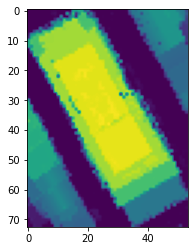

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 54, 'height': 73, 'count': 1, 'crs': CRS.from_epsg(31370), 'transform': Affine(1.0, 0.0, 152215.0,
       0.0, -1.0, 212886.0), 'drivers': 'GTiff'}


In [14]:
m_DTM = rasterio.open('masked_DTM.tif')
m_DSM = rasterio.open('masked_DSM.tif')

DSM_array = m_DSM.read(1)
DTM_array = m_DTM.read(1)
raster_CHM = DSM_array - DTM_array # Canopy Height Model (CHM) = (DSM - DTM)
show(raster_CHM)

print(profile)

# # Create a new file "CHM.tif" and save it into the local drive
with rasterio.open("/home/ms/BeCode/Projects/3D-house-Project/CHM.tif", 'w', **profile) as dst:
    dst.write(raster_CHM, 1)

## 7. 3D Plot

The library used is **plotly**. The 3D Surface plot opens in the browser in a new tab.

In [15]:
CHM = rasterio.open('CHM.tif')
CHM_array = CHM.read(1) # Convert the raster into a Numpy array

#Plot
fig = go.Figure(data=[go.Surface(z=CHM_array)]) # Create the figure from the CHM array
fig.update_layout(title=f'3D Plot - {house_address}', title_x=0.5,
                    scene = dict(
                    xaxis_title='Distance (m)',
                    yaxis_title='Distance (m)',
                    zaxis_title='Height'),
                    font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="RebeccaPurple"))
fig.update_scenes(yaxis_autorange="reversed")
#fig.write_image("image.png", width=1000, height=1000) # Write image to the local drive

plot(fig) # Plot the house in new tab

'temp-plot.html'